In [5]:
import gc, os, sys, time
import pandas as pd, numpy as np
from unidecode import unidecode
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import HTML, display
import warnings
warnings.filterwarnings("ignore")

In [51]:
n_comp = 100 # Specify the number of competitions

# CSV_DIR = Path('..', 'input', 'meta-kaggle')
CSV_DIR = Path('D:/Academics/Research/IORA/Game Designer/Data Files/', 'input', 'meta-kaggle')
if not CSV_DIR.is_dir():
    CSV_DIR = Path('D:/Academics/Research/IORA/Game Designer/Data Files/', 'input')

def read_csv_filtered(csv, col, values):
    dfs = [df.loc[df[col].isin(values)]
           for df in pd.read_csv(CSV_DIR / csv, chunksize=100000, low_memory=False)]
    return pd.concat(dfs, axis=0)

comps = pd.read_csv(CSV_DIR / 'Competitions.csv').set_index('Id')
comps = comps.query("HostSegmentTitle != 'InClass'")
idx = comps.EvaluationAlgorithmName.isnull()
comps.loc[idx, 'EvaluationAlgorithmName'] = comps.loc[idx, 'EvaluationAlgorithmAbbreviation']

comps['EvaluationLabel'] = comps.EvaluationAlgorithmAbbreviation
idx = comps.EvaluationLabel.str.len() > 30
comps.loc[idx, 'EvaluationLabel'] = comps.loc[idx, 'EvaluationLabel'].str.replace(r'[^A-Z\d\-]', '', regex=True)

comps['DeadlineDate'] = pd.to_datetime(comps.DeadlineDate)
comps['EnabledDate'] = pd.to_datetime(comps.EnabledDate)
comps['DeadlineDateText'] = comps.DeadlineDate.dt.strftime('%c')
comps['EnabledDateText'] = comps.EnabledDate.dt.strftime('%c')
comps['Year'] = comps.DeadlineDate.dt.year
comps['RewardQuantity'].fillna('', inplace=True)
comps['Days'] = (comps.DeadlineDate - comps.EnabledDate) / pd.Timedelta(1, 'd')
comps['FinalWeek'] = (comps.DeadlineDate - pd.Timedelta(1, 'w'))

In [53]:
comps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472 entries, 2408 to 35272
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Slug                              472 non-null    object        
 1   Title                             472 non-null    object        
 2   Subtitle                          472 non-null    object        
 3   HostSegmentTitle                  472 non-null    object        
 4   ForumId                           470 non-null    float64       
 5   OrganizationId                    306 non-null    float64       
 6   CompetitionTypeId                 472 non-null    int64         
 7   HostName                          214 non-null    object        
 8   EnabledDate                       472 non-null    datetime64[ns]
 9   DeadlineDate                      472 non-null    datetime64[ns]
 10  ProhibitNewEntrantsDeadlineDate   268 non-nul

In [150]:
comp_eval_count = comps.groupby(['EvaluationLabel','EvaluationAlgorithmIsMax'])[['Slug']].count().sort_values('Slug',ascending=False)
comp_eval_count = comp_eval_count.reset_index()
comp_eval_count = comp_eval_count[comp_eval_count['EvaluationAlgorithmIsMax'] == True]
eval_algo_list = comp_eval_count[comp_eval_count['Slug'] > 5]['EvaluationLabel']
comp_eval_count[comp_eval_count['Slug'] > 5]

,EvaluationLabel,EvaluationAlgorithmIsMax,Slug
0,AUC,True,67
2,CategorizationAccuracy,True,33
7,MAP@{K},True,15
8,MeanFScore,True,9
9,MacroFScore,True,9
10,MeanFScoreBeta,True,8
11,QuadraticWeightedKappa,True,7
13,MAP@k,True,7
14,GoogleGlobalAP,True,6
16,MCAUC,True,6


In [152]:
comps_interest = comps[comps["EvaluationLabel"].isin(eval_algo_list)]
comp_id = comps_interest.sort_values(by=['TotalSubmissions'], ascending=False).index[:n_comp] # Top n competitions ranked by total number of submissions (hotness)

teams = read_csv_filtered('Teams.csv', 'CompetitionId', comp_id).set_index('Id') # Teams that participate in these competitions
tmemb = read_csv_filtered('TeamMemberships.csv', 'TeamId', teams.index).set_index('Id')
users = read_csv_filtered('Users.csv', 'Id', tmemb.UserId)
tmemb = tmemb.merge(users, left_on='UserId', right_on='Id') # Some further cleaning of teams

# Submissions
subs = read_csv_filtered('Submissions.csv', 'TeamId', tmemb.TeamId) # Submission of these teams
subs = subs.rename(columns={'PublicScoreFullPrecision': 'Public'})
subs = subs.rename(columns={'PrivateScoreFullPrecision': 'Private'})
subs['SubmissionDate'] = pd.to_datetime(subs.SubmissionDate)

asfloats = ['PublicScoreLeaderboardDisplay',
            'Public',
            'PrivateScoreLeaderboardDisplay',
            'Private',]

subs[asfloats] = subs[asfloats].astype(float)

subs = subs.query('not IsAfterDeadline').copy()
subs['CompetitionId'] = subs.TeamId.map(teams.CompetitionId)
subs['CompetitionSlug'] = subs.CompetitionId.map(comps.Slug)
subs['TeamName'] = subs.TeamId.map(teams.TeamName)

# values some competitions use as invalid scores
for bad in [99, 999999]:
    for c in asfloats:
        idx = (subs[c] == bad)
        subs.loc[idx, c] = subs.loc[idx, c].replace({bad: np.nan})

# Display order: most recent competitions first
subs = subs.sort_values(['CompetitionId', 'Id'], ascending=[False, True])

In [153]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2573180 entries, 10415310 to 807963
Data columns (total 14 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   Id                              int64         
 1   SubmittedUserId                 float64       
 2   TeamId                          int64         
 3   SourceKernelVersionId           float64       
 4   SubmissionDate                  datetime64[ns]
 5   ScoreDate                       object        
 6   IsAfterDeadline                 bool          
 7   PublicScoreLeaderboardDisplay   float64       
 8   Public                          float64       
 9   PrivateScoreLeaderboardDisplay  float64       
 10  Private                         float64       
 11  CompetitionId                   int64         
 12  CompetitionSlug                 object        
 13  TeamName                        object        
dtypes: bool(1), datetime64[ns](1), float64(6), i

In [212]:
subs[['Public', 'PublicScoreLeaderboardDisplay']]

,Public,PublicScoreLeaderboardDisplay
10415310,0.833741,0.83374
10415311,0.925039,0.92503
10415312,0.916157,0.91615
10531357,0.887718,0.88771
10415313,0.922803,0.92280
...,...,...
66638,0.621698,0.62169
188358,0.843586,0.84358
244991,0.560143,0.56014
82885,0.862308,0.86230


In [154]:
comps_interest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 2439 to 33104
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Slug                              167 non-null    object        
 1   Title                             167 non-null    object        
 2   Subtitle                          167 non-null    object        
 3   HostSegmentTitle                  167 non-null    object        
 4   ForumId                           167 non-null    float64       
 5   OrganizationId                    109 non-null    float64       
 6   CompetitionTypeId                 167 non-null    int64         
 7   HostName                          82 non-null     object        
 8   EnabledDate                       167 non-null    datetime64[ns]
 9   DeadlineDate                      167 non-null    datetime64[ns]
 10  ProhibitNewEntrantsDeadlineDate   92 non-null

In [233]:
useful_cols = ['SubmissionDate',
               'Public',
               'Private',
               'TeamId',
               'TeamName']

# res_df = pd.DataFrame(columns=['n_i', 'x_i', 'n_j', 'x_j', 'y_i','dZ'])
res_list = []
# prob_idx = []
comp_df = pd.DataFrame(columns=['T', 'theta', 'perc'])
comp_length_list = []
prize_list = []

n = 0
threshold = 0.2

for c_id in comp_id:
    slug = comps.loc[c_id]['Slug']
    df = subs.query(f"CompetitionId=={c_id}") # Raw DataFrame for the Competition
    
    if (df['Private'].values >= 1).any() or (df['Private'].values < 0).any():
        print(f'Private score not in [0,1]: {slug}')
        continue

    prize = comps.loc[c_id]['RewardQuantity']
    if type(prize) != float:
        print(f'Non-numerical prize: {slug} -- "{prize}"')
        continue

    prize = prize / 1000
    data_amt = comps.loc[c_id]['LeaderboardPercentage'] / 100
    
    key_col = 'TeamId'
    last_day = df['SubmissionDate'].max()

    names = df[['TeamId', 'TeamName']].drop_duplicates().set_index('TeamId')
    # score = df[df['SubmissionDate'] == last_day].groupby(key_col)['Private'].max().sort_values(ascending=False)
    score = df.groupby(key_col)['Private'].max().sort_values(ascending=False)

    submission = df.groupby(key_col)['SubmissionDate'].count().sort_values(ascending=False)
    submission.name = 'Submissions'

    first_day = df.groupby(key_col)['SubmissionDate'].min()
    first_day.name = 'FirstDay'

    last_day = df.groupby(key_col)['SubmissionDate'].max()
    last_day.name = 'LastDay'

    duration = last_day - first_day
    duration.name = 'Duration'
    
    summary = pd.concat([names, score, duration, first_day, last_day, submission],axis=1).sort_values(['Private', 'Duration', 'Submissions'], ascending=False)
    summary = summary.dropna(axis=0)

    filtered_team = summary.index[:2] # Need Modification for our criteria
    filtered_data = df[df['TeamId'].isin(filtered_team)][useful_cols]
    filtered_data = filtered_data.dropna()
    
    start = filtered_data[filtered_data['Private']!=0].groupby('TeamId')['SubmissionDate'].min().max()

    filtered_data['t'] = (filtered_data.SubmissionDate - start).dt.days // 7 + 1
    n_x = filtered_data.groupby(by=['TeamId', 't']).agg(n =pd.NamedAgg('SubmissionDate', aggfunc='count'),
                                       x = pd.NamedAgg('Private', aggfunc='max'),
                                       public = pd.NamedAgg('Public', aggfunc='max'))
    
    df_i = n_x.loc[filtered_team[0]]
    df_j = n_x.loc[filtered_team[1]]
    df_full = df_i.merge(df_j,left_index=True,right_index=True,how='outer', suffixes=('_i','_j'))
    df_full[['n_i', 'n_j']] = df_full[['n_i', 'n_j']].fillna(0)
    df_full[['x_i', 'x_j', 'public_i', 'public_j']] = df_full[['x_i', 'x_j', 'public_i', 'public_j']].fillna(method='ffill')
    df_full[['x_i', 'x_j', 'public_i', 'public_j']] = df_full[['x_i', 'x_j', 'public_i', 'public_j']].cummax()
    
    if (df_full['n_i'] + df_full['x_i'] == 0).any() or (df_full['n_j'] + df_full['x_j'] == 0).any() :
        # globals()['temp_df'] = filtered_data
        print(f'Inconsistent Participation: {slug}')
        continue
        
    df_full['y_i'] = df_full['x_i'] - df_full['x_j']
    df_full['dZ'] = df_full['public_i'] - df_full['public_j']
    df_full.drop(columns=['public_i', 'public_j'], inplace=True)
    cleaned_data = df_full[df_full.index > 0]
    
    sus_rows = cleaned_data[(cleaned_data[['x_i', 'x_j']] == 0.5).any(axis=1)]
    if sus_rows.shape[0] != 0:
        print(f'Suspect Df: {slug}')
        continue
    # if (np.abs(sus_rows['dZ'] - sus_rows['y_i']) > threshold).any():
    #     print(f'Missing Scores: {slug}')
    #     continue

    # Book Keeping
    comp_len = cleaned_data.shape[0]
    if comp_len <= 2:
        print(f'Too few periods: {slug}')
        continue
    
    res_list.append(cleaned_data)
    # res_df = pd.concat([res_df, cleaned_data])
    comp_df = comp_df.append({'Slug': slug,'T': comp_len, 'theta': prize, 'perc': data_amt}, ignore_index=True)
    n+=1

print(f'Total Competitions Saved: {n}')

res_df = pd.concat(res_list)
res_df.to_csv('cleaned_data.csv', index=False)
comp_df.to_csv('comp_info.csv', index=False)

Private score not in [0,1]: data-science-bowl-2019
Too few periods: cassava-leaf-disease-classification
Private score not in [0,1]: aptos2019-blindness-detection
Private score not in [0,1]: prudential-life-insurance-assessment
Non-numerical prize: dont-overfit-ii -- ""
Private score not in [0,1]: rsna-miccai-brain-tumor-radiogenomic-classification
Private score not in [0,1]: crowdflower-search-relevance
Too few periods: expedia-hotel-recommendations
Private score not in [0,1]: histopathologic-cancer-detection
Private score not in [0,1]: prostate-cancer-grade-assessment
Private score not in [0,1]: landmark-recognition-2020
Private score not in [0,1]: career-con-2019
Private score not in [0,1]: forest-cover-type-prediction
Too few periods: tabular-playground-series-apr-2021
Too few periods: tabular-playground-series-mar-2021
Non-numerical prize: Kannada-MNIST -- ""
Non-numerical prize: flower-classification-with-tpus -- ""
Private score not in [0,1]: ghouls-goblins-and-ghosts-boo
Private

In [234]:
res_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537 entries, 1 to 14
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   n_i     537 non-null    float64
 1   x_i     537 non-null    float64
 2   n_j     537 non-null    float64
 3   x_j     537 non-null    float64
 4   y_i     537 non-null    float64
 5   dZ      537 non-null    float64
dtypes: float64(6)
memory usage: 29.4 KB


In [235]:
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   T       71 non-null     object
 1   theta   71 non-null     object
 2   perc    71 non-null     object
 3   Slug    71 non-null     object
dtypes: object(4)
memory usage: 2.3+ KB


In [221]:
comps_details = comps[comps['Slug'].isin(comp_df['Slug'])]
comps_details.groupby(['EvaluationLabel','EvaluationAlgorithmIsMax'])['Slug'].count()

EvaluationLabel         EvaluationAlgorithmIsMax
AUC                     True                        35
CategorizationAccuracy  True                         8
GoogleGlobalAP          True                         3
MAP@{K}                 True                        11
MCAUC                   True                         6
MacroFScore             True                         2
MeanFScore              True                         3
MeanFScoreBeta          True                         3
Name: Slug, dtype: int64

## Suspicious Data

### Big y_i

In [222]:
threshold = 0.2
for i in range(len(res_list)):
    df = res_list[i]
    sus_rows = df[np.abs(df['y_i']) > threshold]
    if sus_rows.shape[0] != 0:
        print(comp_df.iloc[i]['Slug'])
        print(df)

liverpool-ion-switching
     n_i       x_i   n_j       x_j       y_i        dZ
t                                                     
1    1.0  0.402145  26.0  0.933098 -0.530953 -0.538351
2    0.0  0.402145  35.0  0.937514 -0.535369 -0.539413
3   12.0  0.935256  30.0  0.937894 -0.002638 -0.000665
4    7.0  0.938753  13.0  0.939932 -0.001180 -0.001051
5    6.0  0.938753   8.0  0.939932 -0.001180 -0.001051
6   19.0  0.938813   0.0  0.939932 -0.001119 -0.000852
7   14.0  0.943458   0.0  0.939932  0.003526  0.002761
8    8.0  0.943725   9.0  0.943756 -0.000031 -0.000076
9    3.0  0.944015  25.0  0.944688 -0.000674 -0.001578
10  18.0  0.985096  26.0  0.945267  0.039829 -0.000348
11  15.0  0.985119  13.0  0.958240  0.026879 -0.000673
recursion-cellular-image-classification
    n_i       x_i   n_j       x_j       y_i        dZ
t                                                    
1  31.0  0.645588   5.0  0.978898 -0.333310 -0.506658
2  35.0  0.982659   4.0  0.993593 -0.010934 -0.071767
3  35

### Big Divergence between y_i and dZ

In [224]:
threshold = 0.1
for i in range(len(res_list)):
    df = res_list[i]
    sus_rows = df[(df['y_i'] - df['dZ']) > threshold]
    if sus_rows.shape[0] != 0:
        print(comp_df.iloc[i]['Slug'])
        print(df)

recursion-cellular-image-classification
    n_i       x_i   n_j       x_j       y_i        dZ
t                                                    
1  31.0  0.645588   5.0  0.978898 -0.333310 -0.506658
2  35.0  0.982659   4.0  0.993593 -0.010934 -0.071767
3  35.0  0.990738   1.0  0.995404 -0.004666 -0.029564
4  27.0  0.993105   3.0  0.996030 -0.002925 -0.018957
5  20.0  0.994289   0.0  0.996030 -0.001741 -0.014895
6  26.0  0.994986   7.0  0.996796 -0.001811 -0.014444
7  25.0  0.995891   6.0  0.996796 -0.000905 -0.011284
8  33.0  0.997771  10.0  0.996796  0.000975 -0.004062
9  19.0  0.997911   7.0  0.996796  0.001114 -0.003611
inria-bci-challenge
    n_i       x_i   n_j       x_j       y_i        dZ
t                                                    
1   2.0  0.722253  14.0  0.611427  0.110826  0.007788
3   0.0  0.722253   3.0  0.776981 -0.054728  0.007788
4   3.0  0.770948   5.0  0.776981 -0.006033  0.031129
5   1.0  0.803711   0.0  0.776981  0.026730  0.051676
6   0.0  0.803711   7.

### Submission Number is 0

In [227]:
# for i in range(len(res_list)):
#     df = res_list[i]
#     sus_rows = df[(df[['n_i', 'n_j']] == 0).any(axis=1)]
#     if sus_rows.shape[0] != 0:
#         print(comp_df.iloc[i]['Slug'])
#         print(df)

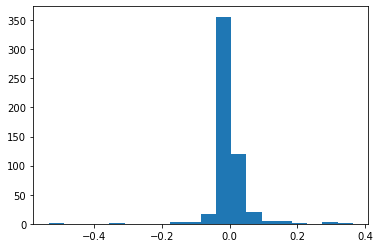

In [228]:
plt.hist(res_df['y_i'], bins=20);

## Dataframes Saved

In [59]:
res_df

,n_i,x_i,n_j,x_j,y_i,dZ
1,21.0,0.796027,12.0,0.792259,0.003768,0.006153
2,18.0,0.797489,17.0,0.789092,0.008397,0.010264
3,37.0,0.794691,18.0,0.792721,0.00197,0.003882
4,58.0,0.796496,15.0,0.795739,0.000757,0.002974
5,39.0,0.798616,29.0,0.795251,0.003366,0.001177
...,...,...,...,...,...,...
9,4.0,0.938919,5.0,0.905786,0.033133,0.004873
10,11.0,0.956714,16.0,0.915345,0.041369,0.004679
1,14,0.956676,13.0,0.956729,-0.000053,0.0
2,5,0.956621,5.0,0.956681,-0.00006,-0.000453


In [60]:
comp_df.head(10)

,T,theta,perc,Slug
0,14,70.0,0.2,home-credit-default-risk
1,11,20.0,0.2,ieee-fraud-detection
2,7,65.0,0.25,santander-customer-transaction-prediction
3,7,30.0,0.3,siim-isic-melanoma-classification
4,9,60.0,0.5,santander-customer-satisfaction
5,6,35.0,0.1,jigsaw-toxic-comment-classification-challenge
6,13,100.0,0.33,tgs-salt-identification-challenge
7,7,25.0,0.18,talkingdata-adtracking-fraud-detection
8,6,100.0,0.2,riiid-test-answer-prediction
9,5,150.0,0.25,tensorflow-great-barrier-reef


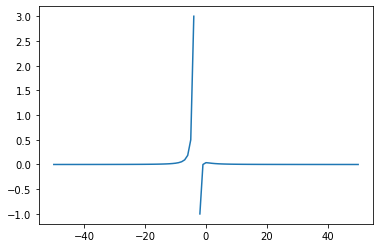

In [246]:
x = np.arange(start=-50,stop=50+1)
def f(x):
    return (x+1)/(x+3)**3
y = f(x)
plt.plot(x,y)

In [242]:
f(-0.1)

0.036901881995981795

In [247]:
min(y)

-inf

In [252]:
x[y == -np.inf]

array([-3])

In [274]:
f(-2.99)

-1990000.0000001276

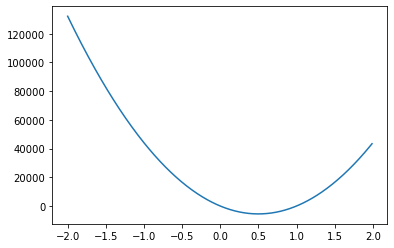

In [276]:
def rho(z):
    return (2*np.cosh(theta)-2)*z**2 - 2*np.sinh(theta)*z + 1

theta = 10
z = np.arange(-2, 2, 0.01)
rho_z = rho(z)
plt.plot(z, rho_z)

In [277]:
idx = np.abs(rho_z - 3).argmin()
print(z[idx])
print(rho_z[idx])

1.7763568394002505e-15
0.9999999999608732
